In [15]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import f, norm, pearsonr, ttest_rel

# Load data
study_name = "Defaults"
specification_name = "default persona"
human_file = f"{study_name} human data labels anonymized.csv"
twin_file = f"{study_name} twins data labels anonymized.csv"
df_human = pd.read_csv(human_file, header=0, skiprows=[1, 2])
df_twin = pd.read_csv(twin_file, header=0, skiprows=[1, 2])


# add new columns with relevant variables coded
# chose target behavior green:
for df in (df_human, df_twin):
    df["target_behavior_green"] = (
        (df["OPTOUT_Green"] == "Stay with GreenGrid") | (df["OPTIN_Green"] == "Switch to GreenGrid")
    ).astype(int)
# chose target behavior organs:
for df in (df_human, df_twin):
    df["target_behavior_organ"] = (
        (
            df["OPTOUT_Organ"]
            == "You are therefore currently a potential donor. If this is acceptable, click here:"
        )
        | (df["OPTIN_Organ"] == "If you wish to change your status, click here:")
    ).astype(int)

# conditon for green
conditions = [
    df_human["OPTOUT_Green"].notna() & df_human["OPTOUT_Green"].str.strip().ne(""),
    df_human["OPTIN_Green"].notna() & df_human["OPTIN_Green"].str.strip().ne(""),
]
choices = ["opt-out", "opt-in"]
for df in (df_human, df_twin):
    df["condition_green"] = np.select(conditions, choices, default=np.nan)

# conditon for organ
conditions = [
    df_human["OPTOUT_Organ"].notna() & df_human["OPTOUT_Organ"].str.strip().ne(""),
    df_human["OPTIN_Organ"].notna() & df_human["OPTIN_Organ"].str.strip().ne(""),
]
choices = ["opt-out", "opt-in"]
for df in (df_human, df_twin):
    df["condition_organ"] = np.select(conditions, choices, default=np.nan)

# check results:
pairs = [
    ("OPTOUT_Green", "target_behavior_green"),
    ("OPTIN_Green", "target_behavior_green"),
    ("OPTOUT_Organ", "target_behavior_organ"),
    ("OPTIN_Organ", "target_behavior_organ"),
    ("OPTOUT_Green", "condition_green"),
    ("OPTIN_Green", "condition_green"),
    ("OPTOUT_Organ", "condition_organ"),
    ("OPTIN_Organ", "condition_organ"),
]

for df_name, df in [("Human", df_human), ("Twin", df_twin)]:
    print(f"\n==== {df_name} sample ====\n")
    for orig, new in pairs:
        print(f"– {orig} vs {new} –")
        ct = pd.crosstab(df[orig], df[new], dropna=False)
        print(ct)
        print()


# define relevant columns:
# condition variable names:
condition_vars = ["condition_green", "condition_organ"]
# Check if we have a real condition var
if condition_vars and condition_vars[0].strip():
    cond = condition_vars[0]
    cond_h = f"{cond}_human"
    cond_t = f"{cond}_twin"
    cond_exists = True
else:
    cond_exists = False


# different condition assignments for each DV (unique to this study)
dv_to_cond = {
    "target_behavior_green": "condition_green",
    "target_behavior_organ": "condition_organ",
}

# raw responses:
raw_vars = []
# raw_vars_min = []
# raw_vars_max = []
# #raw responses: domain=social?
# raw_vars_social=[]
# raw_vars_social_map = dict(zip(raw_vars, raw_vars_social))
# #raw responses: domain=cognitive?
# raw_vars_cognitive=[]
# raw_vars_cognitive_map = dict(zip(raw_vars, raw_vars_cognitive))
# #raw responses: replicating know human bias?
# raw_vars_known=[]
# raw_vars_known_map = dict(zip(raw_vars, raw_vars_known))
# #raw responses: preference measure?
# raw_vars_pref=[]
# raw_vars_pref_map = dict(zip(raw_vars, raw_vars_pref))
# #raw responses: stimuli dependent?
# raw_vars_stim=[]
# raw_vars_stim_map = dict(zip(raw_vars, raw_vars_stim))

# DVs:
DV_vars = ["target_behavior_green", "target_behavior_organ"]
DV_vars_min = [0] * 2
DV_vars_max = [1] * 2
# DVs: domain=social?
DV_vars_social = [0] * 2
DV_vars_social_map = dict(zip(DV_vars, DV_vars_social))
# DVs: domain=cognitive?
DV_vars_cognitive = [0] * 2
DV_vars_cognitive_map = dict(zip(DV_vars, DV_vars_cognitive))
# DVs: replicating know human bias?
DV_vars_known = [1] * 2
DV_vars_known_map = dict(zip(DV_vars, DV_vars_known))
# DVs: preference measure?
DV_vars_pref = [1] * 2
DV_vars_pref_map = dict(zip(DV_vars, DV_vars_pref))
# DVs: stimuli dependent?
DV_vars_stim = [1] * 2
DV_vars_stim_map = dict(zip(DV_vars, DV_vars_stim))
# DVs: knowledge question?
DV_vars_know = [0, 0]
DV_vars_know_map = dict(zip(DV_vars, DV_vars_know))
# DVs: political question?
DV_vars_politics = [0, 0]
DV_vars_politics_map = dict(zip(DV_vars, DV_vars_politics))

# merging key
merge_key = ["TWIN_ID"]

# Merge on TWIN_ID
df = pd.merge(df_human, df_twin, on=merge_key, suffixes=("_human", "_twin"))

# Fix dtypes
for var in raw_vars + DV_vars:
    df[f"{var}_human"] = pd.to_numeric(df[f"{var}_human"], errors="coerce")
    df[f"{var}_twin"] = pd.to_numeric(df[f"{var}_twin"], errors="coerce")

# build min/max maps from both raw_vars and DV_vars
min_map = {v: mn for v, mn in zip(DV_vars, DV_vars_min)}
# min_map = {v: mn for v, mn in zip(raw_vars,      raw_vars_min)}
# min_map.update({v: mn for v, mn in zip(DV_vars,   DV_vars_min)})

max_map = {v: mx for v, mx in zip(DV_vars, DV_vars_max)}
# max_map = {v: mx for v, mx in zip(raw_vars,      raw_vars_max)}
# max_map.update({v: mx for v, mx in zip(DV_vars,   DV_vars_max)})

# now add _min and _max columns for every variable in the union
for var in min_map:
    df[f"{var}_min"] = min_map[var]
    df[f"{var}_max"] = max_map[var]

# Compute results
results = []
# for var in raw_vars:
#     ##############################
#     #07/18/26: condition assignment different for each DV.
# #     col_h = f"{var}_human"
# #     col_t = f"{var}_twin"
# #     min_col = f"{var}_min"
# #     max_col = f"{var}_max"
# #     if cond_exists:
# #         cols = [col_h, col_t, cond_h, cond_t,min_col,max_col]
# #     else:
# #         cols = [col_h, col_t,min_col,max_col]
# #     pair = (
# #     df[cols]
# #       .dropna(subset=[col_h, col_t])
# #     )
# # look up the right condition for this DV
#     cond    = dv_to_cond[var]           # e.g. 'condition_green'
#     cond_h  = f"{cond}_human"           # 'condition_green_human'
#     cond_t  = f"{cond}_twin"            # 'condition_green_twin'
#     col_h   = f"{var}_human"
#     col_t   = f"{var}_twin"
#     min_col = f"{var}_min"
#     max_col = f"{var}_max"
#     # always include the matching condition columns
#     cols = [col_h, col_t, cond_h, cond_t, min_col, max_col]
#     pair = df[cols].dropna(subset=[col_h, col_t, cond_h, cond_t])
# ####################################

#     min_val = pair[min_col].iloc[0]
#     max_val = pair[max_col].iloc[0]
#     n    = len(pair)
#     if n >= 4:
#         r, _    = pearsonr(pair[col_h], pair[col_t])
#         z_f     = np.arctanh(r)
#         se      = 1 / np.sqrt(n - 3)
#         z_crit  = norm.ppf(0.975)
#         lo_z, hi_z = z_f - z_crit*se, z_f + z_crit*se
#         lo_r, hi_r = np.tanh(lo_z), np.tanh(hi_z)
#         z_score    = z_f / se
#         # Accuracy = mean absolute diff / range
#         if pd.isna(min_val) or pd.isna(max_val) or max_val == min_val:
#             accuracy = np.nan
#         else:
#             # compute mean absolute difference
#             abs_diff      = np.abs(pair[col_h] - pair[col_t])
#             mean_abs_diff = abs_diff.mean()
#             accuracy      = 1 - mean_abs_diff / (max_val - min_val)

#         mean_h = pair[col_h].mean()
#         mean_t = pair[col_t].mean()

#         # Paired t‐test
#         t_stat, p_val = ttest_rel(pair[col_h], pair[col_t])

#         std_h = pair[col_h].std(ddof=1)
#         std_t = pair[col_t].std(ddof=1)

#          # F‐test for equal variances
#         df1 = df2 = n - 1
#         f_stat = (std_h**2 / std_t**2) if std_t>0 else np.nan

#         # two‐tailed p‐value:
#         if not np.isnan(f_stat):
#             p_f = 2 * min(f.cdf(f_stat, df1, df2),
#                           1 - f.cdf(f_stat, df1, df2))
#         else:
#             p_f = np.nan

#         # Effect sizes (Cohen's d) across conditions
#         #    For humans:
#         if cond_exists and len(pair)>3:
#             levels_h = pair[cond_h].unique()
#             if len(levels_h) == 2:
#                 g1 = pair.loc[pair[cond_h]==levels_h[0], col_h]
#                 g2 = pair.loc[pair[cond_h]==levels_h[1], col_h]
#                 n1, n2 = len(g1), len(g2)
#                 # pooled sd
#                 s_pool = np.sqrt(((n1-1)*g1.var(ddof=1)+(n2-1)*g2.var(ddof=1)) / (n1+n2-2))
#                 d_human = (g1.mean() - g2.mean()) / s_pool if s_pool>0 else np.nan
#             else:
#                 d_human = np.nan
#         else:
#             d_human = np.nan

#         #    For twins:
#         if cond_exists and len(pair)>3:
#             levels_t = pair[cond_t].unique()
#             if cond_exists and len(levels_t) == 2:
#                 g1 = pair.loc[pair[cond_t]==levels_t[0], col_t]
#                 g2 = pair.loc[pair[cond_t]==levels_t[1], col_t]
#                 n1, n2 = len(g1), len(g2)
#                 s_pool = np.sqrt(((n1-1)*g1.var(ddof=1)+(n2-1)*g2.var(ddof=1)) / (n1+n2-2))
#                 d_twin = (g1.mean() - g2.mean()) / s_pool if s_pool>0 else np.nan
#             else:
#                 d_twin = np.nan
#         else:
#             d_twin = np.nan
#     else:
#         r = lo_r = hi_r = z_score = accuracy = mean_h = mean_t = t_stat = p_val = std_h = std_t = f_stat = p_f = np.nan
#         d_human = d_twin = np.nan


#     results.append({
#         'study name': study_name,
#         'variable name': var,
#         'variable type (raw response/DV)':     'raw',
#         'correlation between the responses from humans vs. their twins':        r,
#         'CI_lower': lo_r,
#         'CI_upper': hi_r,
#         'z-score for correlation between humans vs. their twins':  z_score,
#         'accuracy between humans vs. their twins': accuracy,
#         'mean_human': mean_h,
#         'mean_twin': mean_t,
#         'paired t-test t-stat': t_stat,
#         'paired t-test p-value': p_val,
#         'std_human': std_h,
#         'std_twin': std_t,
#         'variance test F-stat': f_stat,
#         'variance test p-value': p_f,
#         'effect size based on human': d_human,
#         'effect size based on twin': d_twin,
#         'domain=social?':raw_vars_social_map.get(var, np.nan),
#         'domain=cognitive?':raw_vars_cognitive_map.get(var, np.nan),
#         'replicating know human bias?':raw_vars_known_map.get(var, np.nan),
#         'preference measure?':raw_vars_pref_map.get(var, np.nan),
#         'stimuli dependent?':raw_vars_stim_map.get(var, np.nan),
#         'sample size':        n
#     })

for var in DV_vars:
    ##############################
    # 07/18/26: condition assignment different for each DV.
    #     col_h = f"{var}_human"
    #     col_t = f"{var}_twin"
    #     min_col = f"{var}_min"
    #     max_col = f"{var}_max"
    #     if cond_exists:
    #         cols = [col_h, col_t, cond_h, cond_t,min_col,max_col]
    #     else:
    #         cols = [col_h, col_t,min_col,max_col]
    #     pair = (
    #     df[cols]
    #       .dropna(subset=[col_h, col_t])
    #     )
    # look up the right condition for this DV
    cond = dv_to_cond[var]  # e.g. 'condition_green'
    cond_h = f"{cond}_human"  # 'condition_green_human'
    cond_t = f"{cond}_twin"  # 'condition_green_twin'
    col_h = f"{var}_human"
    col_t = f"{var}_twin"
    min_col = f"{var}_min"
    max_col = f"{var}_max"
    # always include the matching condition columns
    cols = [col_h, col_t, cond_h, cond_t, min_col, max_col]
    pair = df[cols].dropna(subset=[col_h, col_t, cond_h, cond_t])
    ####################################

    min_val = pair[min_col].iloc[0]
    max_val = pair[max_col].iloc[0]
    n = len(pair)
    if n >= 4:
        r, _ = pearsonr(pair[col_h], pair[col_t])
        z_f = np.arctanh(r)
        se = 1 / np.sqrt(n - 3)
        z_crit = norm.ppf(0.975)
        lo_z, hi_z = z_f - z_crit * se, z_f + z_crit * se
        lo_r, hi_r = np.tanh(lo_z), np.tanh(hi_z)
        z_score = z_f / se
        # Accuracy = mean absolute diff / range
        if pd.isna(min_val) or pd.isna(max_val) or max_val == min_val:
            accuracy = np.nan
        else:
            # compute mean absolute difference
            abs_diff = np.abs(pair[col_h] - pair[col_t])
            mean_abs_diff = abs_diff.mean()
            accuracy = 1 - mean_abs_diff / (max_val - min_val)

        mean_h = pair[col_h].mean()
        mean_t = pair[col_t].mean()

        # Paired t‐test
        t_stat, p_val = ttest_rel(pair[col_h], pair[col_t])

        std_h = pair[col_h].std(ddof=1)
        std_t = pair[col_t].std(ddof=1)

        # F‐test for equal variances
        df1 = df2 = n - 1
        f_stat = (std_h**2 / std_t**2) if std_t > 0 else np.nan
        # two‐tailed p‐value:
        if not np.isnan(f_stat):
            p_f = 2 * min(f.cdf(f_stat, df1, df2), 1 - f.cdf(f_stat, df1, df2))
        else:
            p_f = np.nan

        # Effect sizes (Cohen's d) across conditions
        #    For humans:
        if cond_exists and len(pair) > 3:
            levels_h = pair[cond_h].unique()
            if len(levels_h) == 2:
                g1 = pair.loc[pair[cond_h] == levels_h[0], col_h]
                g2 = pair.loc[pair[cond_h] == levels_h[1], col_h]
                n1, n2 = len(g1), len(g2)
                # pooled sd
                s_pool = np.sqrt(
                    ((n1 - 1) * g1.var(ddof=1) + (n2 - 1) * g2.var(ddof=1)) / (n1 + n2 - 2)
                )
                d_human = (g1.mean() - g2.mean()) / s_pool if s_pool > 0 else np.nan
            else:
                d_human = np.nan
        else:
            d_human = np.nan

        #    For twins:
        if cond_exists and len(pair) > 3:
            levels_t = pair[cond_t].unique()
            if cond_exists and len(levels_t) == 2:
                g1 = pair.loc[pair[cond_t] == levels_t[0], col_t]
                g2 = pair.loc[pair[cond_t] == levels_t[1], col_t]
                n1, n2 = len(g1), len(g2)
                s_pool = np.sqrt(
                    ((n1 - 1) * g1.var(ddof=1) + (n2 - 1) * g2.var(ddof=1)) / (n1 + n2 - 2)
                )
                d_twin = (g1.mean() - g2.mean()) / s_pool if s_pool > 0 else np.nan
            else:
                d_twin = np.nan
        else:
            d_twin = np.nan
    else:
        r = lo_r = hi_r = z_score = accuracy = mean_h = mean_t = t_stat = p_val = std_h = std_t = (
            f_stat
        ) = p_f = np.nan
        d_human = d_twin = np.nan

    results.append(
        {
            "study name": study_name,
            "persona specification": specification_name,
            "variable name": var,
            #        'variable type (raw response/DV)':     'DV',
            "correlation between the responses from humans vs. their twins": r,
            "CI_lower": lo_r,
            "CI_upper": hi_r,
            "z-score for correlation between humans vs. their twins": z_score,
            "accuracy between humans vs. their twins": accuracy,
            "mean_human": mean_h,
            "mean_twin": mean_t,
            "paired t-test t-stat": t_stat,
            "paired t-test p-value": p_val,
            "std_human": std_h,
            "std_twin": std_t,
            "variance test F-stat": f_stat,
            "variance test p-value": p_f,
            "effect size based on human": d_human,
            "effect size based on twin": d_twin,
            "domain=social?": DV_vars_social_map.get(var, np.nan),
            "domain=cognitive?": DV_vars_cognitive_map.get(var, np.nan),
            "replicating know human bias?": DV_vars_known_map.get(var, np.nan),
            "preference measure?": DV_vars_pref_map.get(var, np.nan),
            "stimuli dependent?": DV_vars_stim_map.get(var, np.nan),
            "knowledge question?": DV_vars_know_map.get(var, np.nan),
            "political question?": DV_vars_politics_map.get(var, np.nan),
            "sample size": n,
        }
    )

# results DataFrame
corr_df = pd.DataFrame(results)
print(corr_df)

# save output as csv - unit of observation is comparison between humans and twins:
out_file = f"{study_name} {specification_name} meta analysis.csv"
corr_df.to_csv(out_file, index=False)


#####participant-level data:
def make_long(df, respondent_type):
    # pick off TWIN_ID + the DVs, then melt
    long = df[["TWIN_ID"] + DV_vars].melt(
        id_vars="TWIN_ID", value_vars=DV_vars, var_name="variable_name", value_name="value"
    )

    long["respondent_type"] = respondent_type
    long["study_name"] = study_name
    long["specification_name"] = specification_name
    return long


# build the two halves
long_h = make_long(df_human, "human")
long_t = make_long(df_twin, "twin")

# stack them
df_long = pd.concat([long_h, long_t], ignore_index=True)

print(df_long.head())
# save output as csv - unit of observation is TWIN_ID:
out_file = f"{study_name} {specification_name} meta analysis individual level.csv"
df_long.to_csv(out_file, index=False)

print("done")


==== Human sample ====

– OPTOUT_Green vs target_behavior_green –
target_behavior_green    0    1
OPTOUT_Green                   
Stay with GreenGrid      0  182
Switch to Twon         118    0
NaN                    192  108

– OPTIN_Green vs target_behavior_green –
target_behavior_green    0    1
OPTIN_Green                    
Stay with Twon         192    0
Switch to GreenGrid      0  108
NaN                    118  182

– OPTOUT_Organ vs target_behavior_organ –
target_behavior_organ                                 0    1
OPTOUT_Organ                                                
If you wish to change your status, click here:      117    0
You are therefore currently a potential donor. ...    0  182
NaN                                                 131  170

– OPTIN_Organ vs target_behavior_organ –
target_behavior_organ                                 0    1
OPTIN_Organ                                                 
If you wish to change your status, click here:        0  17

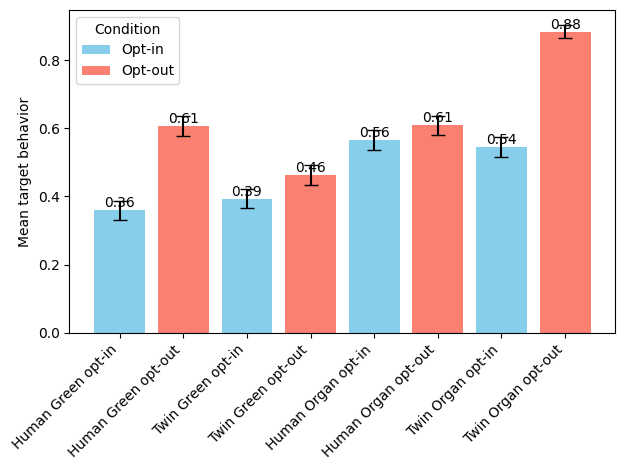

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# define your two data‐groups
groups = {
    "Human": df_human,
    "Twin": df_twin,
}

# the two levels
conditions = ["opt-in", "opt-out"]
# pick two distinct colors for the legend
color_map = {"opt-in": "skyblue", "opt-out": "salmon"}


# helper to compute SEM
def compute_sem(series):
    series = series.dropna()
    return series.std(ddof=1) / np.sqrt(series.count())


labels = []
means = []
sems = []
colors = []

# First 4 bars: target_behavior_green by condition_green
for grp_name, df in groups.items():
    for cond in conditions:
        subset = df[df["condition_green"] == cond]
        labels.append(f"{grp_name} Green {cond}")
        means.append(subset["target_behavior_green"].mean())
        sems.append(compute_sem(subset["target_behavior_green"]))
        colors.append(color_map[cond])

# Next 4 bars: target_behavior_organ by condition_organ
for grp_name, df in groups.items():
    for cond in conditions:
        subset = df[df["condition_organ"] == cond]
        labels.append(f"{grp_name} Organ {cond}")
        means.append(subset["target_behavior_organ"].mean())
        sems.append(compute_sem(subset["target_behavior_organ"]))
        colors.append(color_map[cond])

# Plot
x = np.arange(len(means))
fig, ax = plt.subplots()
bars = ax.bar(x, means, yerr=sems, capsize=5, color=colors)

# Annotate each bar with its mean
for bar, mean in zip(bars, means):
    ax.text(
        bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{mean:.2f}", ha="center", va="bottom"
    )

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel("Mean target behavior")

# Legend for opt‐in vs. opt‐out
legend_handles = [Patch(facecolor=color_map[c], label=c.capitalize()) for c in conditions]
ax.legend(handles=legend_handles, title="Condition")

plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
import statsmodels.formula.api as smf


def run_mixedlm_split_contrast(df_human, df_twin, dv, cond_col):
    # 1) Stack human and twin into one long DataFrame
    df_h = df_human[["TWIN_ID", dv, cond_col]].assign(dataset_dummy=0)
    df_t = df_twin[["TWIN_ID", dv, cond_col]].assign(dataset_dummy=1)
    long = pd.concat([df_h, df_t], ignore_index=True)

    # 2) Code the default contrast: OPTOUT=1, OPTIN=-1
    long["default_contrast"] = long[cond_col].map({"opt-out": 1, "opt-in": -1})
    long = long.dropna(subset=[dv, "default_contrast"])

    # 3) Create separate interaction terms:
    #    - default_contrast_human = default_contrast × (dataset_dummy == 0)
    #    - default_contrast_twin  = default_contrast × (dataset_dummy == 1)
    long["default_contrast_human"] = long["default_contrast"] * (1 - long["dataset_dummy"])
    long["default_contrast_twin"] = long["default_contrast"] * long["dataset_dummy"]

    # 4) Fit mixed‑effects model:
    #    Fixed: default_contrast_human, default_contrast_twin, dataset_dummy
    #    Random intercept: TWIN_ID
    md = smf.mixedlm(
        f"{dv} ~ default_contrast_human + default_contrast_twin + dataset_dummy",
        long,
        groups=long["TWIN_ID"],
        re_formula="1",
    )
    mdf = md.fit()
    print(f"\n--- MixedLM results for {dv} ---")
    print(mdf.summary())


# Run for target_behavior_green
run_mixedlm_split_contrast(
    df_human, df_twin, dv="target_behavior_green", cond_col="condition_green"
)

# Run for target_behavior_organ
run_mixedlm_split_contrast(
    df_human, df_twin, dv="target_behavior_organ", cond_col="condition_organ"
)


--- MixedLM results for target_behavior_green ---
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_behavior_green
No. Observations: 1200    Method:             REML                 
No. Groups:       600     Scale:              0.1509               
Min. group size:  2       Log-Likelihood:     -811.8836            
Max. group size:  2       Converged:          Yes                  
Mean group size:  2.0                                              
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.483    0.020 24.173 0.000  0.444  0.523
default_contrast_human    0.123    0.020  6.168 0.000  0.084  0.163
default_contrast_twin     0.035    0.020  1.750 0.080 -0.004  0.074
dataset_dummy            -0.055    0.022 -2.452 0.014 -0.099 -0.011
Group Var   